- Reference
  - Blog: https://work-in-progress.hatenablog.com/entry/2019/04/06/113629
  - Source: https://github.com/eriklindernoren/Keras-GAN/blob/master/dcgan/dcgan.py

In [1]:
DATA_DIR_PATH = '/content/drive/My Drive/project/ML/dcgan/data'

In [2]:
import os

In [3]:
os.makedirs(os.path.join(DATA_DIR_PATH, 'images'), exist_ok=True)
os.makedirs(os.path.join(DATA_DIR_PATH, 'saved_models'), exist_ok=True)

In [4]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

In [6]:
class DCGAN():
    def __init__(self):
        self.history = pd.DataFrame({}, columns=['d_loss', 'acc', 'g_loss'])

        self.img_save_dir = os.path.join(DATA_DIR_PATH, 'images')
        self.model_save_dir = os.path.join(DATA_DIR_PATH, 'saved_models')
        self.discriminator_name = 'discriminator_model'
        self.generator_name = 'generator_model'
        self.combined_name = 'combined_model'

        self.discriminator = None
        self.generator = None
        self.combined = None

        # NHWC
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        self.latent_dim = 100

    def init(self, loading=False):
        optimizer = Adam(0.0002, 0.5)

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])
        if loading:
            self.load_model_weight(self.discriminator_name)

        self.generator = self.build_generator()
        if loading:
            self.load_model_weight(self.generator_name)

        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.summary()
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        if loading:
            self.load_model_weight(self.combined_name)

    def build_generator(self):
        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation='relu', input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())

        model.add(Conv2D(128, kernel_size=3, padding='same', data_format='channels_last'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation('relu'))

        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding='same', data_format='channels_last'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation('relu'))

        model.add(Conv2D(self.channels, kernel_size=3, padding='same', data_format='channels_last'))
        model.add(Activation('tanh'))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):
        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding='same', data_format='channels_last'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(64, kernel_size=3, strides=2, padding='same', data_format='channels_last'))
        model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(128, kernel_size=3, strides=2, padding='same', data_format='channels_last'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(256, kernel_size=3, strides=1, padding='same', data_format='channels_last'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Flatten())

        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=-1, save_interval=-1):
        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()
        #print(X_train.shape)

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)
        #print(X_train.shape)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        print(datetime.datetime.now().isoformat(), 'Epoch Start')

        for epoch in range(epochs):
            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            self.history = self.history.append({'d_loss': d_loss[0], 'acc': d_loss[1], 'g_loss': g_loss}, ignore_index=True)

            if sample_interval > 0 and epoch % sample_interval == 0:
                print(datetime.datetime.now().isoformat(), '%d [D loss: %f, acc.: %.2f%%] [G loss: %f]' % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.sample_images(epoch)

            if save_interval > 0 and epoch != 0 and epoch % save_interval == 0:
                self.save_model_weights_all()
                
        print(datetime.datetime.now().isoformat(), 'Epoch End')

    def generate_image(self):
        noise = np.random.normal(0, 1, (1, self.latent_dim))
        return self.generator.predict(noise)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0

        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1

        file_name = 'mnist_{}.png'.format(epoch)
        file_path = os.path.join(self.img_save_dir, file_name)
        fig.savefig(file_path)

        plt.close()

    def plot_hisotry(self, columns=[]):
        if len(columns) == 0:
            columns = ['d_loss', 'acc', 'g_loss']
        self.history[columns].plot()
 
    def save_model_weights_all(self):
        self.save_model_weights(self.discriminator, self.discriminator_name)
        self.save_model_weights(self.generator, self.generator_name)
        self.save_model_weights(self.combined, self.combined_name)

    def save_model_weights(self, model, model_name):
        weights_path = os.path.join(self.model_save_dir, '{}.h5'.format(model_name))
        model.save_weights(weights_path)

        print('Weights saved.', model_name)

    def load_model_weight(self, model_name):
        model = None

        if model_name == self.discriminator_name:
            model = self.discriminator
        elif model_name == self.generator_name:
            model = self.generator
        elif model_name == self.combined_name:
            model = self.combined

        if not model:
            print('Model is not initialized.', model_name)
            return

        weights_path = os.path.join(self.model_save_dir, '{}.h5'.format(model_name))

        if not os.path.exists(weights_path):
            print('Not found h5 file.', model_name)
            return

        model.load_weights(weights_path)

        print('Weights loaded.', model_name)

In [7]:
dcgan = DCGAN()
dcgan.init()
#dcgan.init(loading=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 64)          0

In [8]:
# CPU

#dcgan.train(epochs=500, batch_size=32, sample_interval=50, save_interval=50)
#dcgan.train(epochs=500, batch_size=32, sample_interval=50)

#dcgan.train(epochs=10, batch_size=32, sample_interval=5)
#dcgan.save_model_weights_all()

11493376/11490434 [==============================] - 0s 0us/step
2020-07-20T15:57:37.443412 Epoch Start
2020-07-20T15:57:40.497706 0 [D loss: 0.996842, acc.: 34.38%] [G loss: 0.691047]
2020-07-20T15:57:45.375154 5 [D loss: 0.382979, acc.: 81.25%] [G loss: 0.787170]
2020-07-20T15:57:49.262436 Epoch End
Weights saved. discriminator_model
Weights saved. generator_model
Weights saved. combined_model


In [8]:
# GPU
dcgan.train(epochs=10, batch_size=32, sample_interval=5)
dcgan.save_model_weights_all()

11493376/11490434 [==============================] - 0s 0us/step
2020-07-20T16:02:31.141370 Epoch Start
2020-07-20T16:02:39.357368 0 [D loss: 1.225314, acc.: 31.25%] [G loss: 0.671595]
2020-07-20T16:02:41.435375 5 [D loss: 0.586020, acc.: 70.31%] [G loss: 0.725416]
2020-07-20T16:02:43.213001 Epoch End
Weights saved. discriminator_model
Weights saved. generator_model
Weights saved. combined_model


In [9]:
dcgan.train(epochs=1000, batch_size=32, sample_interval=100)
dcgan.save_model_weights_all()

2020-07-20T16:03:46.907783 Epoch Start
2020-07-20T16:03:47.009325 0 [D loss: 0.643444, acc.: 65.62%] [G loss: 0.646848]
2020-07-20T16:03:57.583889 100 [D loss: 0.433916, acc.: 82.81%] [G loss: 0.791360]
2020-07-20T16:04:08.039471 200 [D loss: 0.504763, acc.: 73.44%] [G loss: 1.224822]
2020-07-20T16:04:18.615665 300 [D loss: 0.234860, acc.: 92.19%] [G loss: 1.232537]
2020-07-20T16:04:29.066614 400 [D loss: 0.826676, acc.: 50.00%] [G loss: 1.117438]
2020-07-20T16:04:39.368500 500 [D loss: 0.839814, acc.: 51.56%] [G loss: 1.212676]
2020-07-20T16:04:49.914478 600 [D loss: 0.018969, acc.: 100.00%] [G loss: 1.542393]
2020-07-20T16:05:00.210632 700 [D loss: 0.042990, acc.: 98.44%] [G loss: 1.504795]
2020-07-20T16:05:10.829888 800 [D loss: 0.001260, acc.: 100.00%] [G loss: 0.954591]
2020-07-20T16:05:21.142713 900 [D loss: 0.003456, acc.: 100.00%] [G loss: 1.618272]
2020-07-20T16:05:31.342929 Epoch End
Weights saved. discriminator_model
Weights saved. generator_model
Weights saved. combined_mod

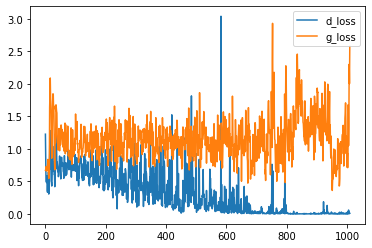

In [10]:
dcgan.plot_hisotry(['d_loss', 'g_loss'])

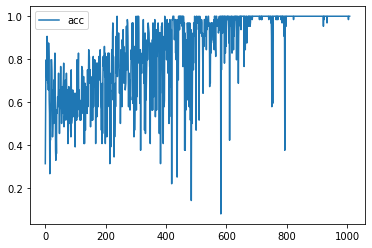

In [11]:
dcgan.plot_hisotry(['acc'])

In [12]:
dcgan.train(epochs=10000, batch_size=32, sample_interval=500)
dcgan.save_model_weights_all()

2020-07-20T16:07:22.947235 Epoch Start
2020-07-20T16:07:23.047640 0 [D loss: 0.015356, acc.: 100.00%] [G loss: 2.640256]
2020-07-20T16:08:13.312742 500 [D loss: 0.000024, acc.: 100.00%] [G loss: 1.711362]
2020-07-20T16:09:03.296855 1000 [D loss: 0.000026, acc.: 100.00%] [G loss: 1.000546]
2020-07-20T16:09:53.327856 1500 [D loss: 0.000025, acc.: 100.00%] [G loss: 3.391934]
2020-07-20T16:10:43.326419 2000 [D loss: 0.000007, acc.: 100.00%] [G loss: 1.765641]
2020-07-20T16:11:33.534383 2500 [D loss: 0.000006, acc.: 100.00%] [G loss: 1.844379]
2020-07-20T16:12:23.530816 3000 [D loss: 0.000008, acc.: 100.00%] [G loss: 2.035414]
2020-07-20T16:13:12.932809 3500 [D loss: 0.000001, acc.: 100.00%] [G loss: 4.661767]
2020-07-20T16:14:02.083858 4000 [D loss: 0.000000, acc.: 100.00%] [G loss: 4.577631]
2020-07-20T16:14:51.582526 4500 [D loss: 0.000001, acc.: 100.00%] [G loss: 4.739819]
2020-07-20T16:15:40.665515 5000 [D loss: 0.000000, acc.: 100.00%] [G loss: 5.057830]
2020-07-20T16:16:31.087085 550

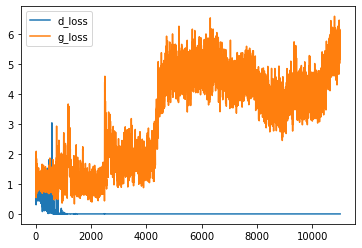

In [14]:
dcgan.plot_hisotry(['d_loss', 'g_loss'])

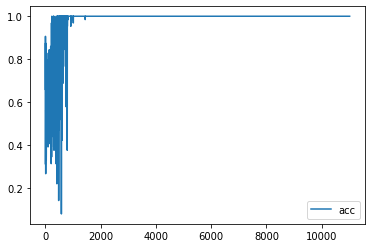

In [15]:
dcgan.plot_hisotry(['acc'])